# Classification Dataset Preparation

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import random
import os
import ast
import re
from nltk.tokenize import sent_tokenize
from sklearn.datasets import fetch_20newsgroups
import contractions
from gensim.utils import tokenize

In [2]:
base_path = '../data/classification/'

## Lyrics Dataset

In [3]:
df = pd.read_csv('../data/lyrics.csv')

In [4]:
df.head()

,lyrics,genre,id
0,"['So long', 'My sweet love', 'I miss you', ""Mo...",pop,0
1,"[""It won't be long before I'm leaving here"", ""...",pop,1
2,"['Are we crazy?', 'Living our lives through a ...",pop,2
3,"['When did it go wrong, I will never know', 'I...",pop,3
4,"[""I've waited all this time"", 'Counting minute...",pop,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lyrics  36000 non-null  object
 1   genre   36000 non-null  object
 2   id      36000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 843.9+ KB


In [6]:
df.drop(columns=['id'])

,lyrics,genre
0,"['So long', 'My sweet love', 'I miss you', ""Mo...",pop
1,"[""It won't be long before I'm leaving here"", ""...",pop
2,"['Are we crazy?', 'Living our lives through a ...",pop
3,"['When did it go wrong, I will never know', 'I...",pop
4,"[""I've waited all this time"", 'Counting minute...",pop
...,...,...
35995,"['Father can you hear me?', 'How have I let yo...",rock
35996,"['In the Kingdom of Spain', 'There are such co...",rock
35997,"['Stagger Lee, can you Do The Locomotion', ""Lu...",rock
35998,"[""Look out, Mama, there's a white boat comin' ...",rock


In [7]:
df = df.rename(columns={'lyrics':'text','genre':'class'})

In [8]:
df['text'] = df['text'].apply(lambda x: ast.literal_eval(x))

In [9]:
df['class'].value_counts()

pop     12000
rap     12000
rock    12000
Name: class, dtype: int64

In [10]:
combinations = [['pop', 'rap', 'rock'], ['pop','rock'], ['rap','rock']]

for combination in combinations:
    # Create id for the configuration        
    ds_id = '-'.join(sorted([re.sub(r'[aeiou]','',c)[:2] for c in combination]))
    
    # Create directory
    data_ds_path = base_path + ds_id

    os.makedirs(data_ds_path, exist_ok=True)
    
    df_sample = df[df['class'].isin(combination)].reset_index()
    df_sample.to_csv(f'{data_ds_path}/data.csv', index=False)

## Rock Lyrics Dataset

In [11]:
df = pd.read_csv('../data/raw-data/lyrics_raw.csv')

In [12]:
df.head()

,lyrics,Axé,Black Music,Blues,Bossa Nova,COLETÂNEA,Chillout,Classic Rock,Clássico,Country,...,Soul Music,Surf Music,Tecnopop,Trance,Trap,Trilha Sonora,Trip-Hop,Tropical House,Velha Guarda,World Music
0,I feel so unsure\nAs I take your hand and lead...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Don't let them fool, ya\nOr even try to school...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Baby, let's cruise, away from here\nDon't be c...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Know it sounds funny\nBut, I just can't stand ...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,You've got that look again\nThe one I hoped I ...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
df.sum(numeric_only=True).sort_values(ascending=False)[:30]

Rock                63717
Pop                 33571
Pop/Rock            26360
Heavy Metal         21759
Hip Hop             20902
Indie               20134
Romântico           17947
Hard Rock           17250
Rap                 17114
R&B                 15581
Rock Alternativo    13061
Black Music         13024
Dance               11895
Folk                11124
Country             10630
Punk Rock            9215
Soul Music           8131
Electronica          7799
Gospel/Religioso     7337
Hardcore             7082
Trilha Sonora        6213
Blues                6094
Gótico               4984
Soft Rock            4483
Progressivo          4365
Jazz                 4343
Tecnopop             3873
Pós-Punk             3274
Reggae               3207
Rockabilly           3100
dtype: int64

In [14]:
genres = ['Pop/Rock','Heavy Metal', 'Hard Rock', 'Rock Alternativo', 'Punk Rock', 'Indie']
lyrics = df['lyrics']

In [15]:
df = df[genres]

In [16]:
df[df.sum(axis=1)==1].sum().sort_values(ascending=False)[:20]

Pop/Rock            22605
Indie               13378
Heavy Metal         12296
Punk Rock            7248
Hard Rock            6335
Rock Alternativo     4783
dtype: int64

In [17]:
df = df.drop(columns=['Rock Alternativo'])

df[df.sum(axis=1)==1].sum().sort_values(ascending=False)[:20]

Pop/Rock       24087
Indie          18091
Heavy Metal    12488
Punk Rock       8170
Hard Rock       7123
dtype: int64

In [18]:
genres = df.columns

In [19]:
df = pd.concat([df, lyrics], axis=1)

In [20]:
df = df.drop(df[df[genres].sum(axis=1)==0].index)

In [21]:
df = df.reset_index(drop=True)

In [22]:
# Duplicates are songs with multiple artists (e.g. a featuring)
# Remove duplicates having the same genre
print(f'Duplicates with the same genre: {df.duplicated().sum()}')
df = df.drop_duplicates()
# Remove lyrics with different genres among duplicates:
print(f'Duplicates with different genres: {df.duplicated(subset="lyrics").sum()}')
df = df.drop_duplicates(subset="lyrics", keep=False)

Duplicates with the same genre: 347


Duplicates with different genres: 125


In [23]:
def clean_text(lyrics):
    lyrics = re.sub(r'\((.+?)?\)', '', lyrics)
    lyrics = re.sub(r'\[(.+?)?\]', '', lyrics)
    lyrics = re.sub(r'\{(.+?)?\}', '', lyrics)
    lyrics = re.sub(r'\n+', '\n', lyrics)
    lyrics = re.sub(r'^[^a-zA-Z]+$', '', lyrics, flags=re.MULTILINE)
    return lyrics

In [24]:
df['lyrics'] = df['lyrics'].apply(clean_text)

In [25]:
# Split lyrics in verses consider \n as sep, filter empty element in list (it's the result of '\n\n' or spaces)
df['lyrics'] = df['lyrics'].apply(
    lambda x: [verse for verse in x.split('\n') if verse.strip()])

In [26]:
# Count number of verses
df['verses'] = df['lyrics'].apply(len)

<AxesSubplot:xlabel='verses', ylabel='Count'>

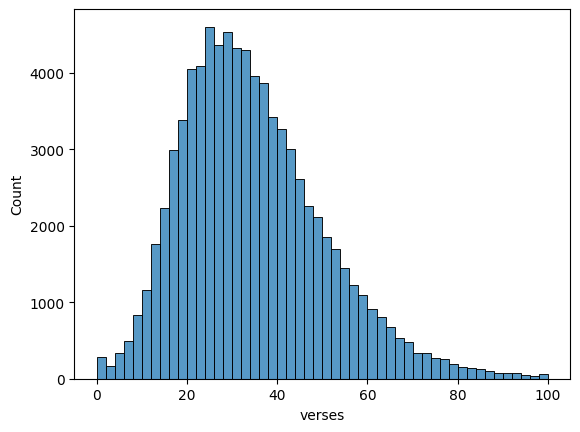

In [27]:
sns.histplot(df['verses'], binrange=(0,100), bins=50)

In [28]:
# Drop the outlier rows from the DataFrame
df = df.drop(df[df['verses'] > 100].index)
df = df.drop(df[df['verses'] < 20].index)

In [29]:
category_col = df[genres].idxmax(axis=1)
df['genre'] = category_col

In [30]:
df['genre'].value_counts()

Pop/Rock       23306
Heavy Metal    17975
Indie          13810
Hard Rock       6743
Punk Rock       5931
Name: genre, dtype: int64

In [31]:
df = df.drop(columns=['verses']+list(genres))

In [32]:
df = df.reset_index(drop=True)

In [33]:
df = df.groupby('genre').sample(n=5000, random_state=42).reset_index(drop=True)

In [34]:
df['genre'] = df['genre'].apply(lambda x: re.sub(r'[/ ]', '-', x.lower()))

In [35]:
df.head()

,lyrics,genre
0,"[What if the devil was a lie?, What if God did...",hard-rock
1,"[Can you help me, Help me get out of this plac...",hard-rock
2,"[For every dream we lose, There's another one ...",hard-rock
3,"[I never seem to find a reason, to let you in ...",hard-rock
4,"[It would appear that male pattern, baldness h...",hard-rock


In [36]:
df = df.rename(columns={'lyrics':'text','genre':'class'})

In [37]:
ds_id = 'rock-subgenres'

# Create directory
data_ds_path = base_path + ds_id

os.makedirs(data_ds_path, exist_ok=True)

df.to_csv(f'{data_ds_path}/data.csv', index=False)

## Movie Plots Dataset

In [38]:
df = pd.read_csv('../data/raw-data/wiki_movie_plots_deduped.csv')

In [39]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [40]:
random.choice(df['Plot'])

"After losing her son Oliver in a car accident in India, Maria has not recovered from the tragedy. During the accident, Maria chose to save her youngest daughter, Lucy instead of Oliver and the guilt devastated her. One night, her husband Michael finds Maria unconscious after a failed suicide attempt. In the hospital, Maria is comforted by her housekeeper Piki. Piki asks Maria if she wants one final chance to say goodbye to Oliver. She explains that in her village, there is an abandoned temple where the line between the living and the dead is very thin. Maria must scatter her son's ashes at the temple steps and lock herself in. Oliver will speak to her once night falls. However, no matter what Oliver says, Maria must not open the temple door for him. Maria agrees and the pair have Oliver's body exhumed and burned. Maria notices some strange men covered in ash. Piki explains that they are shamans who consume the flesh of the dead and coat themselves in ash to strengthen their bonds betw

In [41]:
df['Plot']= df['Plot'].apply(sent_tokenize)

In [42]:
n_sentences = df['Plot'].apply(len)

<AxesSubplot:xlabel='Plot', ylabel='Count'>

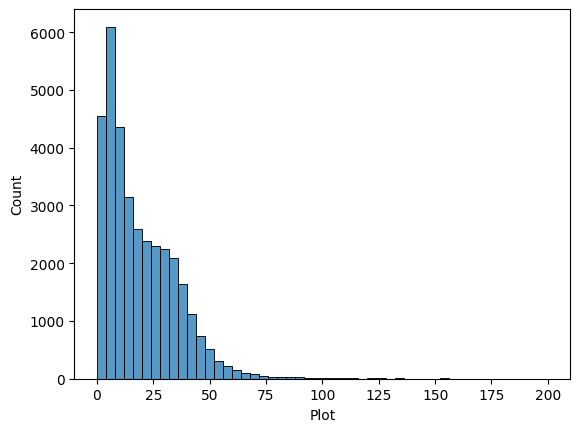

In [43]:
sns.histplot(n_sentences, bins=50, binrange=(0,200))

In [44]:
df = df[df['Plot'].apply(len)>20]

In [45]:
df['Genre'].value_counts().sort_values(ascending=False)[:20]

drama              1887
unknown            1790
comedy             1544
horror              748
action              494
thriller            466
science fiction     302
romance             296
crime drama         238
western             226
adventure           197
romantic comedy     196
animation           174
fantasy             136
musical             134
sci-fi              133
animated            129
war                 124
film noir           123
family              121
Name: Genre, dtype: int64

In [46]:
df = df[df['Genre']!='unknown']
df['Genre'].value_counts().sort_values(ascending=False)[:20]

drama              1887
comedy             1544
horror              748
action              494
thriller            466
science fiction     302
romance             296
crime drama         238
western             226
adventure           197
romantic comedy     196
animation           174
fantasy             136
musical             134
sci-fi              133
animated            129
war                 124
film noir           123
family              121
crime               116
Name: Genre, dtype: int64

In [47]:
def clean_genre_label(label):
    label = ' '.join(label.split()).lower()
    label = re.sub(r'sci[\s-]?fi', 'scifi', label)
    label = re.sub(r'science[-–]fiction', 'scifi', label)
    label = re.sub(r'rom-?com', 'romantic comedy', label)
    label = re.sub(r'[,\.;:\|/\-_–]', ' ', label)    
    label = ' '.join(label.split())
    return label

In [48]:
df['Genre'] = df['Genre'].apply(clean_genre_label)

In [49]:
dummies = df['Genre'].str.get_dummies(sep=' ')
df = pd.concat([df['Plot'], dummies], axis=1)

In [50]:
df.sum(numeric_only=True).sort_values(ascending=False)[:20]

drama        3351
comedy       2758
action       1220
horror       1007
thriller      945
romance       716
crime         604
adventure     406
science       402
fiction       397
fantasy       351
family        335
musical       329
romantic      291
war           280
animated      277
western       266
scifi         260
animation     233
film          220
dtype: int64

In [51]:
df = df[['Plot',
         'drama',
         'comedy',
         'thriller','action','crime',
         'horror','scifi','fantasy','mystery','supernatural']]

In [52]:
df.sum(numeric_only=True).sort_values(ascending=False)

drama           3351
comedy          2758
action          1220
horror          1007
thriller         945
crime            604
fantasy          351
scifi            260
mystery          167
supernatural      28
dtype: int64

In [53]:
group1 = 'action_thriller_crime'
group2 = 'horror_scifi_mystery_supernatural_fantasy'

In [54]:
df.loc[:, group1] = df[group1.split('_')].max(axis=1)
df.loc[:, group2] = df[group2.split('_')].max(axis=1)

df = df.drop(columns=group1.split('_')+group2.split('_'))

In [55]:
df = df.drop(df[df.sum(axis=1, numeric_only=True)!=1].index)

In [56]:
df = df.reset_index(drop=True)

In [57]:
genres = [col for col in df.columns if col != 'Plot']

category_col = df[genres].idxmax(axis=1, numeric_only=True)
df['genre'] = category_col

df = df.drop(columns=genres)

In [58]:
df['genre'].value_counts()

drama                                        2496
comedy                                       2113
action_thriller_crime                        1590
horror_scifi_mystery_supernatural_fantasy    1313
Name: genre, dtype: int64

In [59]:
df['genre'].value_counts(normalize=True)

drama                                        0.332268
comedy                                       0.281283
action_thriller_crime                        0.211661
horror_scifi_mystery_supernatural_fantasy    0.174787
Name: genre, dtype: float64

In [60]:
df = df.rename(columns={'Plot':'text','genre':'class'})

In [61]:
ds_id = 'movie-plots'

# Create directory
data_ds_path = base_path + ds_id

os.makedirs(data_ds_path, exist_ok=True)

df.to_csv(f'{data_ds_path}/data.csv', index=False)

## 20 Newsgroups

In [62]:
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

df = pd.DataFrame({'text': newsgroups.data,
                   'category': [newsgroups.target_names[value]
                                for value in newsgroups.target]})

In [63]:
religion = ['talk.religion.misc', 'alt.atheism', 'soc.religion.christian']
df['macro_category'] = [cat.split('.')[0]
                        if cat not in religion else 'religion'
                        for cat in df['category']]

In [64]:
def clean_text(text):
  # Remove hyperlinks, html, email adress
  text = re.sub(r'https?://\S+|www\.\S+','',text)
  text = re.sub(r'<.*?>', '', text)
  text = re.sub(r'[a-zA-Z0-9\._-]+@[a-zA-Z0-9\._-]+', '', text)
  # Contractions
  text = contractions.fix(text)
  # Remove multiple spaces
  text = ' '.join(text.split())
  # Avoid repetition of the same symbol
  text = re.sub(r'(\W)( ?\1)+',  r'\1', text)
  return text

In [65]:
df['text'] = df['text'].apply(clean_text)

In [66]:
df['text'] = df['text'].apply(sent_tokenize)

In [67]:
df['n_sentences'] = df['text'].apply(len)

In [68]:
df.groupby('category')['n_sentences'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
talk.politics.mideast,940.0,21.461702,54.465665,0.0,4.0,8.0,19.0,777.0
talk.politics.misc,775.0,17.347097,46.105676,0.0,4.0,8.0,14.0,486.0
soc.religion.christian,997.0,16.008024,22.336104,0.0,5.0,9.0,19.0,285.0
talk.religion.misc,628.0,13.788217,29.335078,0.0,3.0,6.0,15.0,547.0
sci.crypt,991.0,13.115035,33.298268,0.0,3.0,6.0,12.0,530.0
alt.atheism,799.0,12.617021,28.851682,0.0,3.0,6.0,12.0,516.0
talk.politics.guns,910.0,12.201099,20.214259,0.0,3.0,7.0,13.0,380.0
comp.graphics,973.0,12.103803,47.702422,0.0,3.0,5.0,8.0,544.0
comp.windows.x,988.0,12.063765,41.966033,0.0,3.0,5.0,9.0,535.0


In [69]:
df[df['n_sentences']>20]['category'].value_counts()

soc.religion.christian      227
talk.politics.mideast       218
talk.politics.guns          135
talk.politics.misc          120
sci.crypt                   118
talk.religion.misc          114
alt.atheism                  99
sci.med                      97
rec.sport.hockey             90
sci.space                    89
rec.sport.baseball           77
comp.graphics                59
comp.os.ms-windows.misc      52
comp.windows.x               50
rec.autos                    44
comp.sys.ibm.pc.hardware     44
misc.forsale                 40
sci.electronics              37
rec.motorcycles              34
comp.sys.mac.hardware        31
Name: category, dtype: int64

In [70]:
df.groupby('macro_category')['n_sentences'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
macro_category,,,,,,,,
talk,2625.0,17.036571,42.956925,0.0,4.0,8.0,15.0,777.0
religion,2424.0,14.315182,26.535201,0.0,4.0,7.0,16.0,547.0
sci,3952.0,10.792763,27.029130,0.0,3.0,6.0,10.0,785.0
comp,4891.0,10.308935,38.166062,0.0,3.0,5.0,9.0,1210.0
rec,3979.0,8.200302,15.425581,0.0,3.0,5.0,9.0,468.0
misc,975.0,6.734359,8.609257,0.0,3.0,5.0,8.0,156.0


In [71]:
df[df['n_sentences']>20]['macro_category'].value_counts()

talk        473
religion    440
sci         341
rec         245
comp        236
misc         40
Name: macro_category, dtype: int64

In [72]:
df = df[df['n_sentences']>20]

In [73]:
df = df.drop(columns=['category','n_sentences'])

In [74]:
df = df.reset_index(drop=True)

In [75]:
df = df.rename(columns={'macro_category':'class'})

In [76]:
ds_id = '20ng'

# Create directory
data_ds_path = base_path + ds_id

os.makedirs(data_ds_path, exist_ok=True)

df.to_csv(f'{data_ds_path}/data.csv', index=False)